# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [3]:
#Импортируем необходимые библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [4]:
#Загрузим данные
try:
    data=pd.read_csv('C:/Users/ARTEM/Desktop/DataScience/users_behavior.csv')
except:
    data=pd.read_csv('/datasets/users_behavior.csv')

In [5]:
#Взглянем на первые 10 строк датасета
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [6]:
#Изучим типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [7]:
#Изменим типы в столбцах 'calls' и 'messages'с float64 на int64
data['calls']=data['calls'].astype('int64')
data['messages']=data['messages'].astype('int64')

In [8]:
#Проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [9]:
#Посмотрим, на данные в таком разрезе
data.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


##### Вывод:
- датасет загружен
- изменены типы данных в столбцах messages/calls c float64 на int64
- пропуски/аномалии не обнаружены

## Разбейте данные на выборки

In [10]:
#Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую,  валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1. 
data_train, data_valid_test = train_test_split(data, test_size=0.6, random_state=12345)
data_test, data_valid = train_test_split(data_valid_test, test_size=0.5, random_state=12345)
print('Размер обучающей выборки -', len(data_train))
print('Размер тестовой выборки -', len(data_test))
print('Размер валидационной выборки -', len(data_valid))

Размер обучающей выборки - 1285
Размер тестовой выборки - 964
Размер валидационной выборки - 965


In [11]:
#Определим целевой признак для обущающей выборки и признаки
features_train = data_train.drop('is_ultra', axis=1)
target_train = data_train['is_ultra']
#Определим целевой признак для тестовой выборки и признаки
features_test = data_test.drop('is_ultra', axis=1)
target_test = data_test['is_ultra']
#Определим целевой признак для валидационной выборки и признаки
features_valid = data_valid.drop('is_ultra', axis=1)
target_valid = data_valid['is_ultra']

## Исследуйте модели

### Рассмотрим 3 основные модели, которые были пройдены в курсе:

In [12]:
#Самый важный гиперпараметр решающего дерева — max_depth, переберем возможные значение от 1 до 10, чтобы получить наиболее качественную модель
best_model_dc = None
best_result_dc = 0
max_depth_list=[]
accuracy_score_list=[]
criterion=['gini','entropy']
for el in criterion:
    for i in range(1,11):
        model_dc=DecisionTreeClassifier(random_state=12345,max_depth=i, criterion=el)
        max_depth_list.append(i)
        model_dc.fit(features_train, target_train)
        result_dc=model_dc.score(features_valid, target_valid)
        accuracy_score_list.append(result_dc)
        if result_dc > best_result_dc:
            k=i
            best_el=el
            best_model_dc = model_dc
            best_result_dc = result_dc 
   
print("Accuracy наилучшей модели на валидационной выборке:", best_result_dc, 'c гиперпараметром max_depth',k, 'и гиперпараметром criterion',best_el)

Accuracy наилучшей модели на валидационной выборке: 0.7865284974093264 c гиперпараметром max_depth 6 и гиперпараметром criterion entropy


In [13]:
max_depth_list[0:10]
accuracy_score_list[0:10]

[0.7440414507772021,
 0.7585492227979275,
 0.7772020725388601,
 0.7792746113989637,
 0.7772020725388601,
 0.7813471502590673,
 0.7751295336787565,
 0.7772020725388601,
 0.7678756476683938,
 0.7492227979274612]

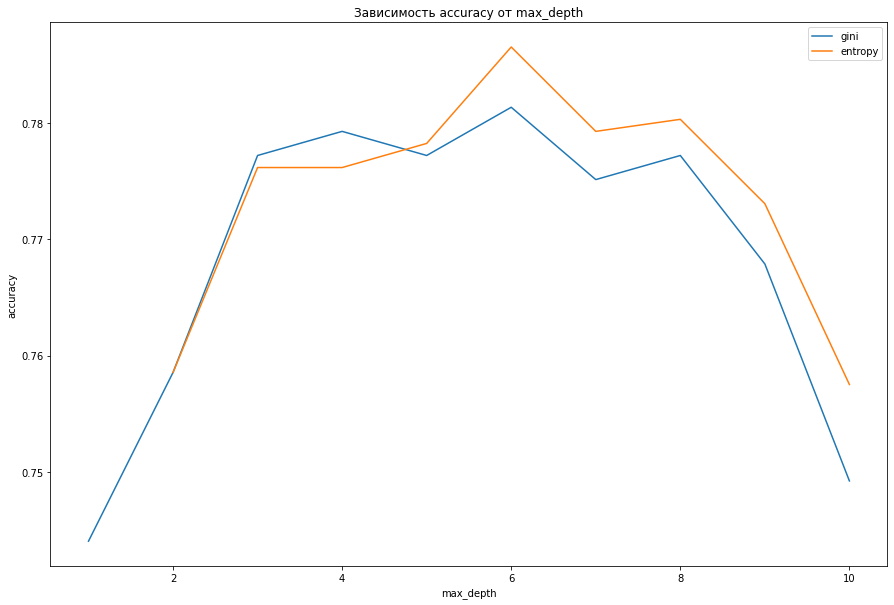

In [14]:
plt.figure(figsize=(15,10))
plt.title('Зависимость accuracy от max_depth')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.plot(max_depth_list[0:10],accuracy_score_list[0:10])
plt.plot(max_depth_list[11:20],accuracy_score_list[11:20])
plt.legend(criterion)



#### 2. Cлучайный лес

Попробую применить GridSearchCV, как в рекомендации, а проверять буду следующие гиперпараметры:
<br>
n_estimators – Число деревьев в лесу. Оно будет изменяться от 1 до 13 с шагом 1
<br>
max_depth – Глубина дерева. Она будет изменяться от 1 до 6 с шагом в 1
<br>
min_samples_leaf – Минимальное число образцов для сплита. Оно будет изменяться от 1 до 8.

In [15]:
# Присвоем модель без гиперпараметров,а для самих гиперпараметров подготовим словарь paramers
model_rf= RandomForestClassifier()
parametrs = {'n_estimators': range (1, 14),
              'max_depth': range (1,6),
              'min_samples_leaf': range (1,8)}

In [16]:
# используем GridSeachCV для поиска оптимальных параметров
grid = GridSearchCV(model_rf, parametrs, cv=4)
grid.fit(features_train, target_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 6),
                         'min_samples_leaf': range(1, 8),
                         'n_estimators': range(1, 14)})

In [17]:
# Выведем наилучшие гиперпараметры
grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 6, 'n_estimators': 4}

In [18]:
# Используя лучшие гиперпараметры проверим результат
model_rf= RandomForestClassifier(max_depth=5,random_state=12345,min_samples_leaf=3,n_estimators=10)
model_rf.fit(features_train, target_train)
result_rf = model_rf.score(features_valid, target_valid) 

In [19]:
print('Accuracy наилучшей модели на валидационной выборке',result_rf)

Accuracy наилучшей модели на валидационной выборке 0.7803108808290156


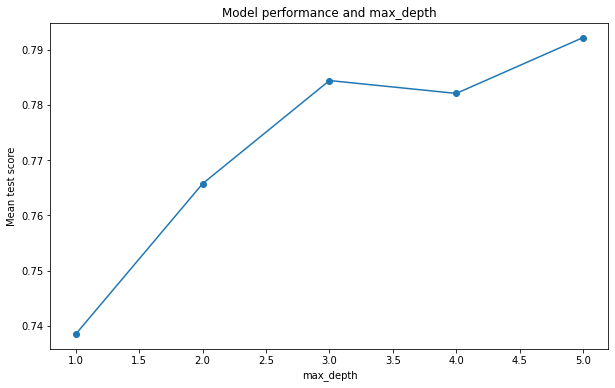

In [20]:
# Код ревьюера

import matplotlib.pyplot as plt

param_grid = {'max_depth': range (1,6)}

# Обучаем GridSearchCV и сохраняем результаты
grid = GridSearchCV(DecisionTreeClassifier(random_state=12345), param_grid=param_grid, cv=5)
grid.fit(features_train, target_train)

results = grid.cv_results_

# Получаем средние результаты на тестовых наборах для каждого параметра max_depth
test_scores = results['mean_test_score']

# Получаем значения параметра max_depth
max_depth_values = [param['max_depth'] for param in results['params']]

# Построим график
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, test_scores, marker='o')
plt.title('Model performance and max_depth')
plt.xlabel('max_depth')
plt.ylabel('Mean test score')
plt.show()

In [29]:
test_scores = results['mean_test_score']
test_scores

array([0.7385214 , 0.76575875, 0.7844358 , 0.78210117, 0.7922179 ])

#### 3. Логическая регрессия

In [21]:
#Построим модель логической регрессии
model_lr = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000) 
model_lr.fit(features_train,target_train) 
model_lr.score(features_valid, target_valid) 
print("Accuracy линейной регрессии:", model_lr.score(features_valid, target_valid))

Accuracy линейной регрессии: 0.7398963730569948


In [22]:
#Построим модель логической регрессии
solver=['lbfgs', 'liblinear']
best_model_lr = None
best_result_lr = 0
for solv in solver:
        model_lr=LogisticRegression(random_state=12345,max_iter=1000, solver=solv)
        model_lr.fit(features_train, target_train)
        result_lr=model_lr.score(features_valid, target_valid)
        if result_lr > best_result_lr:
            s=solv
            best_model_lr = model_lr
            best_result_lr = result_lr

In [23]:
print('Accuracy наилучшей модели на валидационной выборке',best_result_lr, 'с гиперпараметром solver',s)

Accuracy наилучшей модели на валидационной выборке 0.7419689119170985 с гиперпараметром solver lbfgs


## Вывод:
Подведем итоги 3 обученных моделей:

Дерево решений: Максимальная глубина дерева 6, доля правильный ответов на валидационной выборке 0.7813471502590673
<br>
<br>
Случайный лес:Максимальное количество деревьев 38,доля правильный ответов  на валидационной выборке 0.7792746113989637
<br>
<br>
Логистическая регрессия:
Доля правильный ответов на валидационной выборке 0.7419689119170985

Наиболее точная модель - дерево решений!

## Проверьте модель на тестовой выборке

In [24]:
#Проверим модель на тестовой выборке
result_test=model_dc.score(features_test, target_test)
print('Accuracy выбранной модели на тестовой выборке:',result_test)

Accuracy выбранной модели на тестовой выборке: 0.7873443983402489


##### Вывод:
Доля чуть выше, чем на валидационной выборке, но различие совсем невелико

## (бонус) Проверим модели на адекватность

In [25]:
print('valid -',best_result_dc)
print('test -',result_test)
print('Модель весьма адекватна, т.к. accuracy практически не различается')

valid - 0.7865284974093264
test - 0.7873443983402489
Модель весьма адекватна, т.к. accuracy практически не различается


In [26]:
1-data['is_ultra'].sum()/data['is_ultra'].count()

0.693528313627878

### Вывод:
По результатам работы:
    
- Изучен и проанализирован датасет
- Датасет разбит на три выборки: обучающая, валидационная и тестовая в соотношении 1:1:3
- Исследованы три модели классификации: Дерево решений, Случайный лес и Логистическая регрессия.
- Найдены оптимальные параметры для каждой модели и выбрана оптимальная!
- Модель проверена на тестовой выборке, оценена адекватность.